In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#import datasets
#countries = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/countries.csv")
#age_gender = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/age_gender_bkts.csv")
#sessions = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/sessions.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/test_users.csv")
train_users = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/train_users_2.csv")

In [0]:
#first few rows of train_users dataset
print(train_users.head())
#training set info
print(train_users.info())

           id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender   age signup_method  signup_flow language affiliate_channel  \
0  -unknown-   NaN      facebook            0       en            direct   
1       MALE  38.0      facebook            0       en               seo   
2     FEMALE  56.0         basic            3       en            direct   
3     FEMALE  42.0      facebook            0       en            direct   
4  -unknown-  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app 

In [0]:
#drop columns that we do not need
train_users = train_users.drop(["id","timestamp_first_active",'signup_flow','affiliate_channel',
                                'first_affiliate_tracked','signup_app','first_device_type','first_browser',
                               'signup_method','affiliate_provider'], axis = 1)
#these are the only relevant columns we need
train_users.head()

,date_account_created,date_first_booking,gender,age,language,country_destination
0,2010-06-28,NaN,-unknown-,NaN,en,NDF
1,2011-05-25,NaN,MALE,38.0,en,NDF
2,2010-09-28,2010-08-02,FEMALE,56.0,en,US
3,2011-12-05,2012-09-08,FEMALE,42.0,en,other
4,2010-09-14,2010-02-18,-unknown-,41.0,en,US


In [0]:
#first looking at the gender values, we must replace -unknown- as a NaN value
train_users.gender.replace('-unknown-', np.nan, inplace=True)
train_users['gender'].head()
train_users['gender'].describe()

count     117763
unique         3
top       FEMALE
freq       63041
Name: gender, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


THERE ARE 63041 FEMALES IN THIS DATASET
THERE ARE 54440 MALES IN THIS DATASET


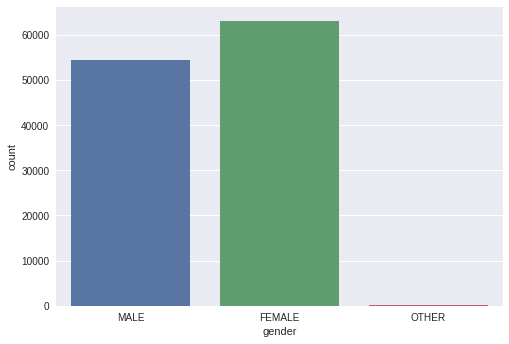

In [0]:
#see the distribution of gender in the training set
plot_gender = sns.countplot(train_users['gender'])
print("THERE ARE " + str(sum((train_users['gender'] == 'FEMALE'))) + " FEMALES IN THIS DATASET")
print("THERE ARE " + str(sum((train_users['gender'] == 'MALE'))) + " MALES IN THIS DATASET")


In [0]:
#find out values for the age column
print(train_users['age'].describe())
#set outliers to NaN values if they are older than 90 years old and younger than 14
train_users.loc[train_users.age > 90, 'age'] = np.nan
train_users.loc[train_users.age < 14, 'age'] = np.nan

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


count    122861.000000
mean         36.463809
std          11.455232
min          15.000000
25%          28.000000
50%          33.000000
75%          42.000000
max          90.000000
Name: age, dtype: float64


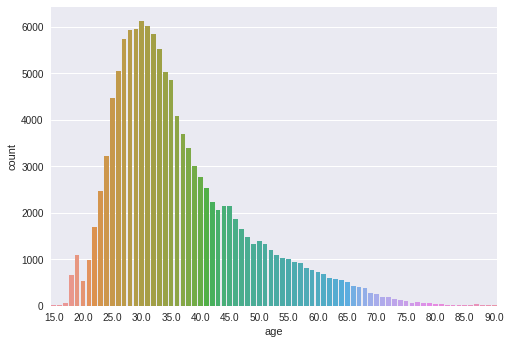

In [0]:
#visualize the age in this dataset
plot_age = sns.countplot(train_users['age'])
#limiting tick frequency for ease of readability 
for ind, label in enumerate(plot_age.get_xticklabels()):
    if ind % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
print(train_users['age'].describe())

plot_age 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


count     213451
unique        12
top          NDF
freq      124543
Name: country_destination, dtype: object


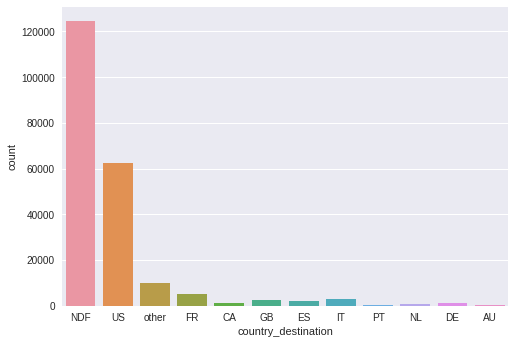

In [0]:
#visualize where airbnb guests are going to
plot_dest = sns.countplot(train_users['country_destination'])
print(train_users['country_destination'].describe())

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(10, 60)

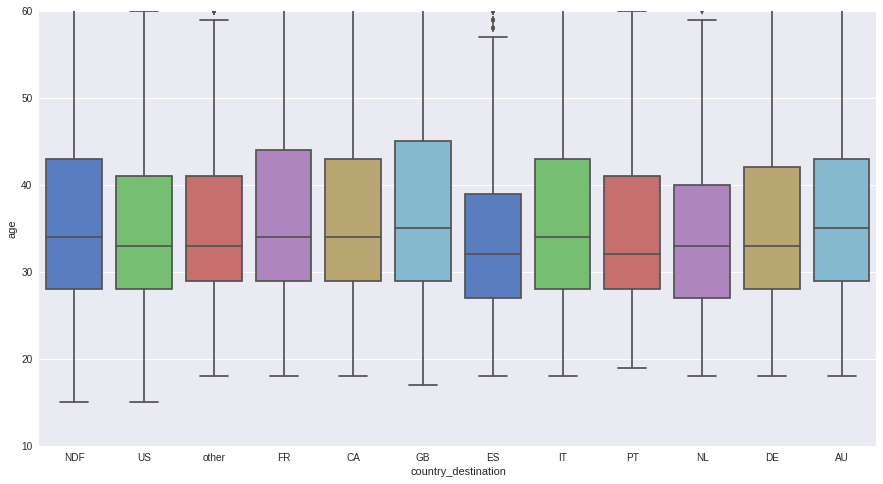

In [0]:
#box plot of which ages that visit each country
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=train_users, palette="muted", ax =ax)
ax.set_ylim([10, 60])

In [0]:
#see where male and females visit the most

#sum of females and males
female = sum(train_users['gender'] == 'FEMALE')
male = sum(train_users['gender'] == 'MALE')

#total count of males and females to which country they visit
female_dest = train_users.loc[train_users['gender'] == 'FEMALE', 'country_destination'].value_counts()
male_dest = train_users.loc[train_users['gender'] == 'MALE', 'country_destination'].value_counts()

Text(0,0.5,'Count')

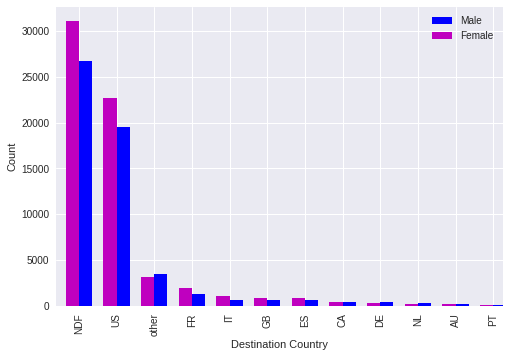

In [0]:
#plot country_destination and number of males/females
male_dest.plot(kind='bar', width=.35, color='b', position=0, label='Male')
female_dest.plot(kind='bar', width=.35, color='m', position=1, label='Female')
plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Count')

The age distribution seems to be resembling a normal distribution, with the average age hovering around 30 years old. 

In [0]:
#date = date_first_booking - date_account_created
train_users['date_account_created'] = pd.to_datetime(train_users['date_account_created'])
train_users['date_first_booking'] = pd.to_datetime(train_users['date_first_booking'])
train_users['date'] = train_users['date_first_booking'] - train_users['date_account_created']
train_users['date'] = train_users['date'].dt.days
train_users['date'].describe()

count    88908.000000
mean        44.362498
std         87.499561
min       -349.000000
25%          1.000000
50%          3.000000
75%         29.000000
max        365.000000
Name: date, dtype: float64

In [0]:
#drop rows with negative date
train_users = train_users[(train_users['date'] >= 0) | train_users['date'].isnull()]

In [0]:
train_users.head()

,date_account_created,date_first_booking,gender,age,language,country_destination,date
0,2010-06-28,NaT,NaN,NaN,en,NDF,NaN
1,2011-05-25,NaT,MALE,38.0,en,NDF,NaN
3,2011-12-05,2012-09-08,FEMALE,42.0,en,other,278.0
5,2010-01-01,2010-01-02,NaN,NaN,en,US,1.0
6,2010-01-02,2010-01-05,FEMALE,46.0,en,US,3.0


In [0]:
#drop rows with NaN values
train_users = train_users.dropna(subset=['gender','age','language'], how='any')
train_users.head()

,date_account_created,date_first_booking,gender,age,language,country_destination,date
1,2011-05-25,NaT,MALE,38.0,en,NDF,NaN
3,2011-12-05,2012-09-08,FEMALE,42.0,en,other,278.0
6,2010-01-02,2010-01-05,FEMALE,46.0,en,US,3.0
7,2010-01-03,2010-01-13,FEMALE,47.0,en,US,10.0
8,2010-01-04,2010-07-29,FEMALE,50.0,en,US,206.0


In [0]:
#one-hot encode genders (male, female, other)
gender = pd.get_dummies(train_users['gender'])
train_users = train_users.merge(gender,left_index = True, right_index = True)

In [0]:
#one-hot encode country-destinations into a single column
#create a dictionary of values corresponding to each country destination
#{'other': 0, 'US': 1, 'FR': 2, 'CA': 3, 'GB':4, 'ES':5, 'IT': 6, 'PT': 7, 'NL': 8, 'DE': 9, 'AU': 10, 'NDF': 11}

# Assigning a value to our countries 
bool = train_users.country_destination == 'US'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 1

bool = train_users.country_destination == 'FR'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 2

bool = train_users.country_destination == 'CA'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 3

bool = train_users.country_destination == 'GB'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 4

bool = train_users.country_destination == 'ES'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 5

bool = train_users.country_destination == 'IT'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 6

bool = train_users.country_destination == 'PT'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 7

bool = train_users.country_destination == 'NL'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 8

bool = train_users.country_destination == 'DE'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 9

bool = train_users.country_destination == 'AU'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 10

bool = train_users.country_destination == 'other'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 0

bool = train_users.country_destination == 'NDF'
column_name = 'country_destination'
train_users.loc[bool, column_name] = 11

In [0]:
train_users['month_first_booked'] = pd.DatetimeIndex(train_users['date_first_booking']).month
train_users = train_users.drop(["gender", 'date_account_created'], axis=1)
#convert language to binary values where 1 is english and 0 if otherwise
train_users['language'] = np.where(train_users['language'] == 'en', 1, 0)

In [0]:
#one-hot encode months
month_first = pd.get_dummies(train_users['month_first_booked'])
month_first.columns  = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
month_first['NaT'] = np.where(pd.isna(train_users['month_first_booked']), 1, 0)
train_users = train_users.merge(month_first,left_index = True, right_index = True)

In [0]:
#clean up columns we do not need
train_users = train_users.drop(['date_first_booking','month_first_booked'], axis=1)

#fill in the NaN values in age column with the average age
avg = np.mean(train_users['age']).astype(int)
train_users['age'] = train_users['age'].fillna(avg)

#fill in NaT values in date column with a large number
train_users['date'] = train_users['date'].fillna(-1)

#reformatting our final cleaned dataset
cd = train_users["country_destination"]
train_users = train_users.drop(["country_destination"], axis=1)
train_users["country_destination"] = cd
train_users.head()

,age,language,date,FEMALE,MALE,OTHER,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,NaT,country_destination
1,38.0,1,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11
3,42.0,1,278.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,46.0,1,3.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7,47.0,1,10.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
8,50.0,1,206.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [0]:
train_users.tail()

,age,language,date,FEMALE,MALE,OTHER,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,NaT,country_destination
213440,24.0,1,-1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11
213441,34.0,1,44.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5
213443,36.0,1,13.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
213445,23.0,1,2.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
213446,32.0,1,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11


# Logistic Regression

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

dataset = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/dataset.csv")

# Dataset Done

# K folds cross validation
def crossValidation(dummyData, folds):
    testAccuracies = []
    for i in range(0, folds):
        # Randomize Data
        dummyData.sample(frac=1)
        
        X = dummyData.iloc[:, :-1].values
        y = dummyData.iloc[:, -1].values
        
        xRows, xCols = X.shape
        
        X = np.reshape(X, (xRows, xCols))
        y = np.reshape(y, (xRows, 1))
  
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
  
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
  
        trainRows, trainCols = X_train.shape
        testRows, testCols = X_test.shape
        
        X_train = np.reshape(X_train, (trainRows, trainCols))
        y_train = np.reshape(y_train, (trainRows, 1))
        X_test = np.reshape(X_test, (testRows, testCols))
        y_test = np.reshape(y_test, (testRows, 1))
  
        classifier = LogisticRegression(random_state = 0, multi_class='ovr')
        classifier.fit(X_train, y_train)
  
        # Predicts probabilities
        y_pred = classifier.predict_proba(X_test)
  
        # Find the max column index per row
        y_max = np.argmax(y_pred, axis=1)
  
        sum = 0
  
        for i in range(0, testRows):
            if y_max[i] == y_test[i]:
                sum += 1
                
        acc = sum/testRows
        testAccuracies.append(acc)
        return np.mean(testAccuracies)

print(crossValidation(dataset, 5))

# NDF Baseline
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
ndf = 0
for i in range(0, 213422):
    if y[i] == 11:
        ndf += 1
print(ndf/213422)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8810382795295881
0.5835527733785645


# Decision Tree

In [0]:
# Converting Dataframe to an Array and Organizing Data
training_array = train_users.values
X_train_val = training_array[:int(len(train_users)*.8),:19]
Y_train_val = training_array[:int(len(train_users)*.8),19]
X_test = training_array[int(len(train_users)*.8):,:19]
Y_test = training_array[int(len(train_users)*.8):,19]

In [0]:
# Training the Decision Tree Model
model = tree.DecisionTreeClassifier()
D = [1,3,5,7,9]
clf = GridSearchCV(model,{'max_depth':D},cv=5)
clf.fit(X_train_val, Y_train_val)
train_acc = clf.cv_results_['mean_train_score']
val_acc = clf.cv_results_['mean_test_score']
print(train_acc, val_acc)

[0.84730437 0.84730437 0.84733658 0.84753277 0.84841413] [0.84730437 0.84730437 0.84715211 0.84656649 0.84421228]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


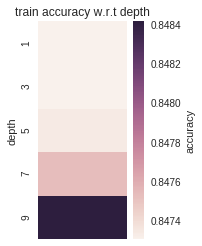

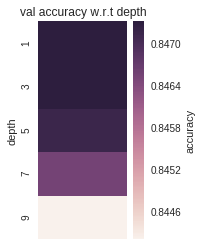

In [0]:
# Visualizing with heatmaps
# Credit to UCSD's 118a instructional team for this function
def draw_heatmap_linear(acc, acc_desc, depth_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=depth_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='depth')
    plt.title(acc_desc + ' w.r.t depth')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

train_acc = train_acc.reshape((5,1))
draw_heatmap_linear(train_acc, 'train accuracy', D)

val_acc = val_acc.reshape((5,1))
draw_heatmap_linear(val_acc, 'val accuracy', D)

In [0]:
# Testing the Decision Tree Model
clf = tree.DecisionTreeClassifier(max_depth=9)
clf.fit(X_train_val,Y_train_val)
pred = clf.predict(X_test)
errors = np.count_nonzero(pred-Y_test)
test_acc = (Y_test.size - errors)/Y_test.size
print(test_acc)

0.8460997891777934


## Neural Network

In [0]:
# Training the MLP Classifier
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='adam',alpha=0.0001,learning_rate='adaptive',shuffle=True)
hidden_units = [100]
hidden_layers = [1,2]
clf = GridSearchCV(model,{'hidden_layer_sizes':(hidden_units,hidden_layers)},cv=5)
clf.fit(X_train_val,Y_train_val)
train_acc = clf.cv_results_['mean_train_score']
val_acc = clf.cv_results_['mean_test_score']
print(train_acc, val_acc)

[0.84738051 0.77357994] [0.8470467  0.77358601]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [0]:
# Testing the MLP Classifier
model = MLPClassifier(hidden_layer_sizes = (100,1),\
                      solver='adam',alpha=0.0001,learning_rate='adaptive')
clf.fit(X_train_val,Y_train_val)
pred = clf.predict(X_test)
errors = np.count_nonzero(pred-Y_test)
test_acc = (Y_test.size - errors)/Y_test.size
print(test_acc)

0.8495197938627314


## K-Nearest Neighbors

### Using less features to avoid the curse of dimensionality

In [0]:
lower_dim = train_users.drop(['OTHER', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'NaN'], axis=1)
X_lower = lower_dim.iloc[:, :-1].values
y_lower = lower_dim.iloc[:, 5].values
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lower, y_lower, test_size=0.20)  
scaler = StandardScaler()
scaler.fit(X_train_l)
X_train_l = scaler.transform(X_train_l)
X_test_l = scaler.transform(X_test_l)
error_l = []
accuracy_l = []

### Testing different values of k

In [0]:
for i in [5,10,25,50,70,90,100,461]:  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_l, y_train_l)
    y_pred_l = knn.predict(X_test_l)
    error_l.append(np.mean(y_pred_l != y_test_l))
    accuracy_l.append(accuracy_score(y_test_l, y_pred_l))

In [0]:
for i in [55,60,65]:  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_l, y_train_l)
    y_pred_l = knn.predict(X_test_l)
    error_l.append(np.mean(y_pred_l != y_test_l))
    accuracy_l.append(accuracy_score(y_test_l, y_pred_l))

In [0]:
k = [5,10,25,50,70,90,100,461,55,60,65]
kval = pd.DataFrame(columns = ["k", "error", "accuracy"])
kval["k"] = k
kval["error"] = error_l
kval["accuracy"] = accuracy_l
kval.sort_values(by="k")

In [0]:
kval.plot.scatter(x="k", y="error")
plt.ylim(0.12,0.145)
plt.xlim(0,105)
plt.title("Error Rate for Various k")

In [0]:
kval.plot.scatter(x="k", y="accuracy")
plt.xlim(0,105)
plt.title("Accuracy for Various k")

### Comparing to using all 19 features

In [0]:
X = train_users.iloc[:, :-1].values
y = train_users.iloc[:, 19].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=60)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.mean(y_pred != y_test))
print(accuracy_score(y_test, y_pred))

### Modifying data to have no NDF and less US

In [0]:
no_ndf = train_users[train_users.country_destination != 11]
us = no_ndf[no_ndf['country_destination'] == 1]
no_us = no_ndf[no_ndf['country_destination'] != 1]
smaller_us = us.head(50000)
df = pd.DataFrame()
df = df.append(smaller_us)
df = df.append(no_us)
lower_df = df.drop(['OTHER', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'NaN'], axis=1)
shuffled_df = lower_df.sample(frac=1)
X_lower = shuffled_df.iloc[:, :-1].values
y_lower = shuffled_df.iloc[:, 5].values
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lower, y_lower, test_size=0.20)  
scaler = StandardScaler()
scaler.fit(X_train_l)
X_train_l = scaler.transform(X_train_l)
X_test_l = scaler.transform(X_test_l)

In [0]:
error_l = []
accuracy_l = []
for i in [5,10,30,60,461]:  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_l, y_train_l)
    y_pred_l = knn.predict(X_test_l)
    print("Using k=" + str(i) + " we predict countries: " + str(set(y_pred_l)))
    error_l.append(np.mean(y_pred_l != y_test_l))
    accuracy_l.append(accuracy_score(y_test_l, y_pred_l))

In [0]:
k_l = [5,60,100,461,1000]
kval_l = pd.DataFrame(columns = ["k", "error", "accuracy"])
kval_l["k"] = k_l
kval_l["error"] = error_l
kval_l["accuracy"] = accuracy_l
kval_l.sort_values(by="k")